### Curve-fitting in a single CSTR reactor model

reference: SciPy ode.integrate module https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

optimisation: Scipy.optimize.minimize_scalar https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar

#### Mass balance for a single CSTR:

$$ 
\frac{\partial{C}}{\partial{t}} = F_{in} - F_{out} = F_{in} - \frac{q}{V}C = \frac{q}{V}(C_{in}-C)
$$
Inlet concentration changes as a square wave: 
$$
\begin {cases}
C_{in} = 0,      t<t_{start}, t>t_{end} \\
C_{in} = C_{in},      t_{end}<t<t_{start}
\end {cases}
$$
Objective function: sum of squares:
$$
Error = \sum{(C_{exp}-C_{model})^2}
$$
Fitted paremeter is: $ q $


In [1]:
import numpy as np
import matplotlib.pyplot as p
import scipy
from scipy.interpolate import interp1d
from scipy.stats import norm

#### This defines initial conditions:

In [13]:
time_start = 40 #integration start time
time_stop = 100 # integration stop time
inj_start = 57 #injection start time
inj_stop = 65 #ingection stop time

#Initial conditions:
c0 = 0 # [mol/s]
V = 1 #[ml?]
c_in = 3.15e-8 #[mol/s]

#### Defining ODE for CSTR model, and feed profile:

In [3]:
#function that defines right side of ODE equation:
def cstr_ode(t, c, c_in, q, V):
    dcdt = q/V*(feed(t)*c_in - c)
    return dcdt

#function that defines injection:
def feed(t):
     if t<inj_start:
        return 0
     elif t>inj_stop:
        return 0
     else:
        return 1

#### Function for solving ODE model, and to return the transient concentration profile:

In [4]:
#Function that takes parameter to be optimised and returns 
def cstr(q):   
    #calling an integration function and assign the output to sol object
    fun = lambda t, c: cstr_ode(t, c, c_in, q, V)
    sol = scipy.integrate.solve_ivp(fun, [time_start,time_stop], [c0], rtol = 1e-10, atol = 1e-10, max_step = 0.1)
    t = sol.t 
    c = sol.y[0] # output is in multidimensional array, getting 1st dimension
    c = interp1d(t, c) #interpolation to sync with experimental sampling 
    return c, t

#### Objective function:

In [6]:
def obj_fun(q):
    model_data, model_time = cstr(q)
    x = np.sum((exp_data-model_data(exp_time))**2, axis = 0)
    return x

#### Importing and plotting experimental data:

4.81637e-07


Text(0, 0.5, 'Molar Flow, [mol/s]')

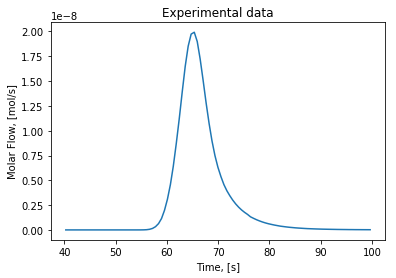

In [14]:
#import:
data = []
f = open('data.txt')
for line in f:
    data.append(float(line.replace('E', 'e')))
time = []
f = open('time.txt')
for line in f:
    time.append(float(line))
print(data[4])
calibration = 690000 #Hand-chosen number, need to find from experiment

exp_data = np.array(data)/calibration
exp_time = np.array(time)

#Selecting the needed experimental data
inlet = exp_time>time_start
exp_time = exp_time[inlet]
exp_data = exp_data[inlet]
stop = exp_time<time_stop
exp_time = exp_time[stop]
exp_data = exp_data[stop]

p.plot(exp_time, exp_data)
p.title('Experimental data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')

#### Sample of simulation (q = 1) before fitting, random noise is added:

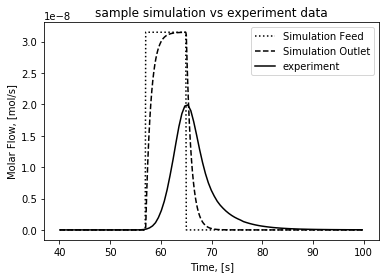

In [19]:
set_q = 1
y_data, x_data = cstr(set_q)
y_data = y_data(x_data)
feed_data = list(range(len(x_data)))
for i, j in enumerate(x_data):
    feed_data[i] = feed(j)*3.15e-8
p.plot(x_data, feed_data, 'k:', label = 'Simulation Feed')
p.plot(x_data, y_data, 'k--', label = 'Simulation Outlet')
p.plot(exp_time, exp_data, 'k', label = 'experiment')
p.title('sample simulation vs experiment data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')
p.legend()

#### Optimisation by finding minimum:

In [8]:
res = scipy.optimize.minimize_scalar(obj_fun)
q_found = res.x
print(f'Optimal parameter is {q_found}')
res

Optimal parameter is 0.11403610879003964


     fun: 6.416453092214034e-16
    nfev: 19
     nit: 15
 success: True
       x: 0.11403610879003964

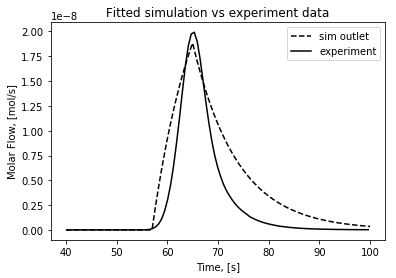

In [21]:
model_data, model_time = cstr(q_found)
model_data = model_data(model_time)
#p.plot(x_data, feed_data, label = 'sim inlet')
p.plot(model_time, model_data, 'k--', label = 'sim outlet')
p.plot(exp_time, exp_data, 'k', label = 'experiment')
p.title('Fitted simulation vs experiment data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')
p.legend()

3.3181016513777114e-16


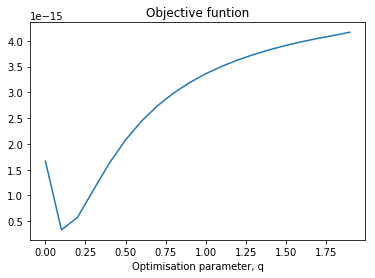

In [11]:
#Optional: long computing time!
#Prints objective funtion over a range of parameters:
q_start = 0
q_end = 2
N = 20 #Number of sample points

cf = np.zeros(N)
q = np.zeros(N)
for i in range(N):
    q[i] = q_start + abs(q_start-q_end)*i/N
    model_data, model_time = cstr(q[i])
    model_data = model_data(exp_time)
    cf[i] = 0.5*np.sum((exp_data-model_data)**2, axis = 0)
    
p.plot(q, cf)
p.title('Objective funtion')
p.xlabel('Optimisation parameter, q')
print(min(cf))